In [5]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.gridspec import GridSpec
import seaborn as sns

import ssm
from ssm.util import random_rotation
from ssm.plots import plot_dynamics_2d
import scipy.io

# Specify whether or not to save figures
save_figures = False

In [30]:
temp_data = scipy.io.loadmat('primarymotorSpikesArthur1.mat')['ySpikes'].astype(int)
num_trials, num_bins, num_neurons = np.shape(temp_data)
spikes = [temp_data[ii_trial, :, :] for ii_trial in range(np.shape(temp_data)[0])]

(104, 160)


In [43]:
state_dim = 3
lds = ssm.LDS(num_neurons, state_dim, emissions="poisson_orthog", emission_kwargs=dict(link = 'softplus'))
elbos, q = lds.fit(spikes, method="laplace_em", num_iters=10) # EM fitting
state_means = q.mean_continuous_states # Get the posterior mean of the continuous states

ARHMM Initialization restarts:   0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


ELBO: -60753.9: 100%|██████████| 10/10 [01:35<00:00,  9.51s/it]


In [44]:
smoothed_obs = np.zeros([num_trials, num_bins, num_neurons])

for ii_trial in range(num_trials):

    smoothed_obs[ii_trial, :, :] = lds.smooth(state_means[ii_trial], spikes[ii_trial]) # Smooth the data under the variational posterior


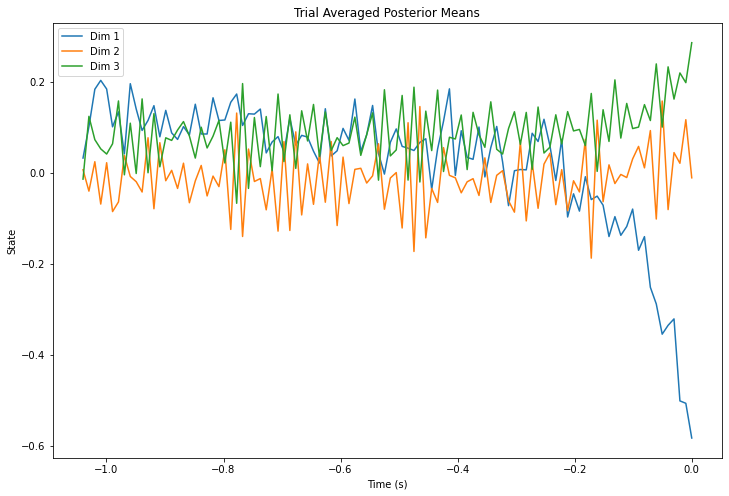

<Figure size 432x288 with 0 Axes>

In [45]:
state_means_array = np.zeros([num_trials, num_bins, state_dim])

for ii_trial in range(num_trials):

    state_means_array[ii_trial, :, :] = state_means[ii_trial]

# Get the mean for each of the dimensions

mean_state_means = np.mean(state_means_array, axis = 0)
bin_size = .01
time = bin_size * np.linspace(-num_bins, -bin_size, num_bins)
labels = ['Dim 1', 'Dim 2', 'Dim 3']

plt.figure(figsize = (12, 8))
lines = plt.plot(time, mean_state_means)
plt.xlabel('Time (s)')
plt.ylabel('State')
plt.title('Trial Averaged Posterior Means')
plt.legend(lines, labels)
plt.show()
plt.savefig('trial_averaged_posterior_means_pm.png')

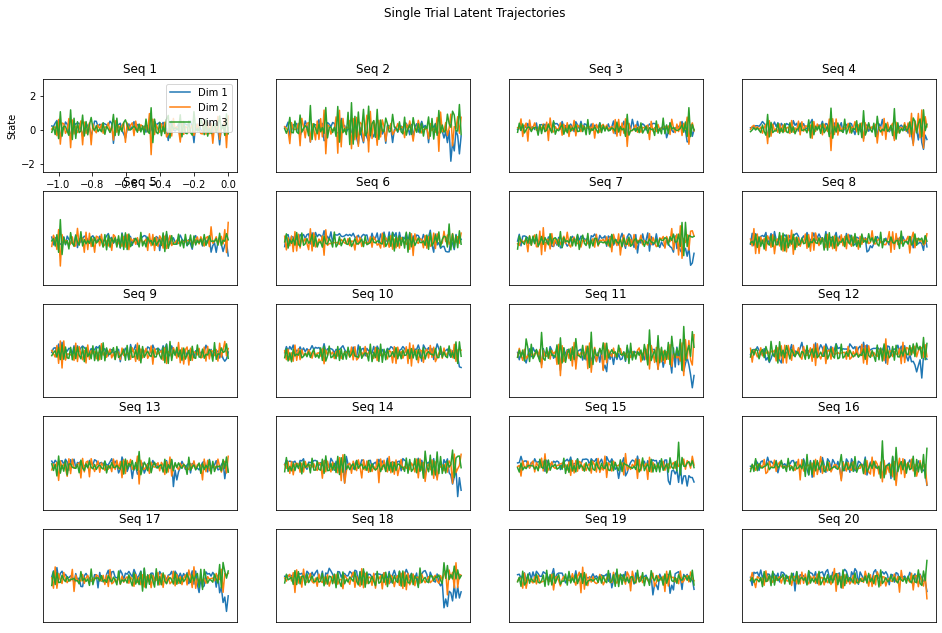

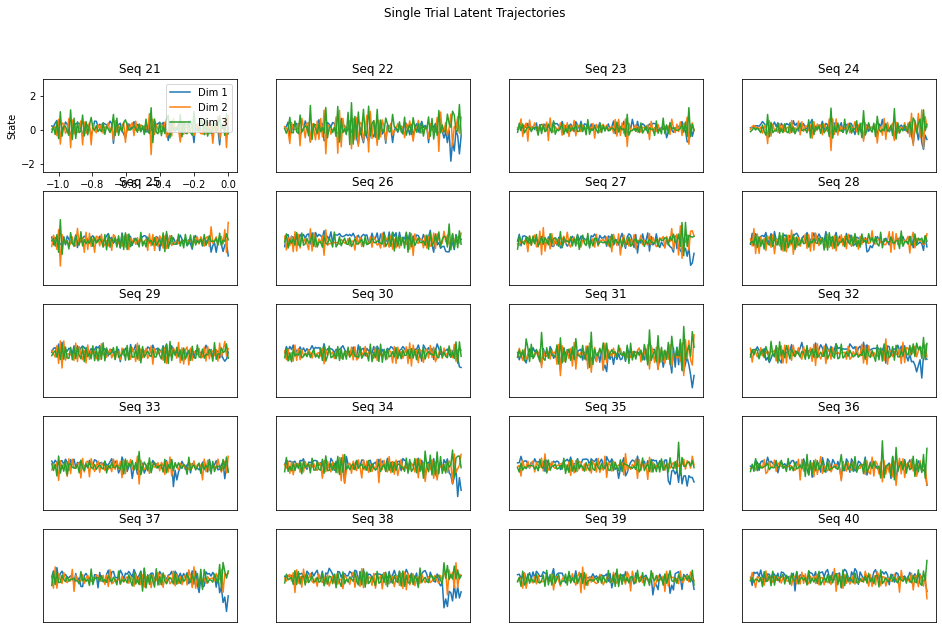

In [46]:
# Plot a couple of the single trials on subplots

num_trials_plot = 20
num_plots = int(num_trials / num_trials_plot)

for ii_plot in range(num_plots):

    plt.figure(figsize = (16, 10))
    plt.suptitle('Single Trial Latent Trajectories')

    for jj_trial in range(num_trials_plot):

        plt.subplot(5, 4, jj_trial + 1)
        lines = plt.plot(time, state_means[jj_trial])
        plt.ylim([-2.5, 3])
        
        if jj_trial == 0:

            plt.legend(labels)
            plt.xlabel('Time (s)')
            plt.ylabel('State')

        else:

            plt.xticks([])
            plt.yticks([])

        plt.title(f'Seq {ii_plot * num_trials_plot + jj_trial + 1}')

    plt.savefig(f'single_trial_latents_{ii_plot}.png')


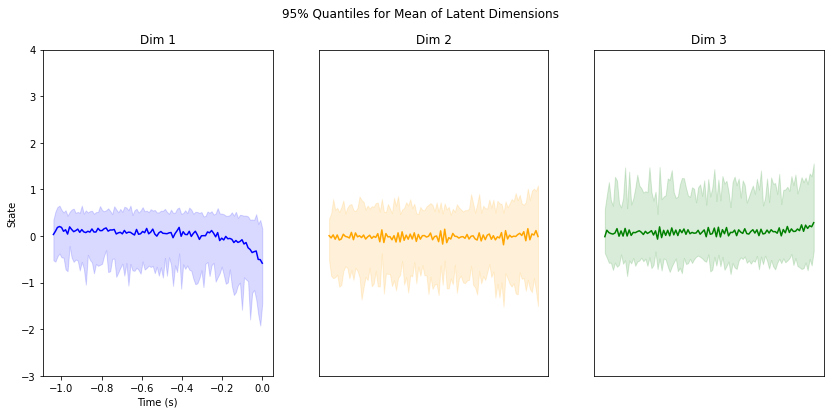

In [47]:
# Plot the 95% confidence bands for each of the latent dimensions

quantiles = [.025, .975]
conf_bands = {}
colors = ['blue', 'orange', 'green']

for ii_dim in range(state_dim):

    conf_bands[f'dim_{ii_dim + 1}'] = np.quantile(state_means_array[:, :, ii_dim], quantiles, axis = 0).T

plt.figure(figsize = (14, 6))
plt.suptitle('95% Quantiles for Mean of Latent Dimensions')

for ii_subplot in range(state_dim):

    plt.subplot(1, 3, ii_subplot + 1)
    plt.title(f'Dim {ii_subplot + 1}')
    plt.plot(time, mean_state_means[:, ii_subplot], color = colors[ii_subplot])
    plt.fill_between(time, conf_bands[f'dim_{ii_subplot + 1}'][:, 0], conf_bands[f'dim_{ii_subplot + 1}'][:, 1], 
        color = colors[ii_subplot], alpha = .15)
    plt.ylim([-3, 4])
    
    if ii_subplot == 0:
    
        plt.xlabel('Time (s)')
        plt.ylabel('State')

    else:

        plt.xticks([])
        plt.yticks([])

plt.savefig('quantiles_latent_dimensions.png')

In [97]:
# Plot the reproduced average firing rates on top of the actual firing rates

state_to_param = np.copy(lds.emissions.Cs)[0]
state_to_param_bias = np.copy(lds.emissions.ds)
lambdas = np.zeros([num_trials, num_bins, num_neurons])

In [96]:
# Get Poisson rate parameters

for ii_trial in range(num_trials):

    for jj_bin in range(num_bins):

        lambdas[ii_trial, jj_bin, :] = np.log1p(np.exp(state_to_param @ state_means_array[ii_trial, jj_bin, :].reshape(state_dim, 1) + state_to_param_bias.T)).flatten()

# Sample the inhomogenous poisson process from the rate_params_trials vector

pred_spikes = np.random.poisson(lam = lambdas)

In [ ]:
# Stack rasters on top of each other for all neurons, given trial

for ii_trial in range(num_trials):

    pred_spike_times = []
    real_spike_times = []

    for jj_neuron in range(num_neurons):

        pred_spike_times = np.append(pred_spike_times, [bin_size * kk_index if pred_spikes[ii_trial][kk_index, jj_neuron] > 0 else None for kk_index in range(num_bins)])
        real_spike_times = np.append(real_spike_times, [bin_size * kk_index if spikes[ii_trial][kk_index, jj_neuron] > 0 else None for kk_index in range(num_bins)])


    plt.figure(figsize = (12, 8))
    plt.subplot(1, 2, 1)
    plt.eventplot(real_spike_times, color = 'red')
    plt.eventplot(pred_spike_times, color = 'black')




    
# Plot smoothed firing rates on same subplot, different lines
# Average activity in general, single neuron? How should we do this



In [103]:
print([bin_size * kk_index if spikes[0][kk_index, 100] > 0 else None for kk_index in range(num_bins)])

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [105]:
np.where(spikes != 0)

(array([0]),)